In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"albertnathaniel12","key":"26a0c7ba67b423ed4719b9e00a06612d"}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d albertnathaniel12/indonesian-spices-dataset

Dataset URL: https://www.kaggle.com/datasets/albertnathaniel12/indonesian-spices-dataset
License(s): DbCL-1.0
100% 400M/402M [00:16<00:00, 26.7MB/s]
100% 402M/402M [00:16<00:00, 25.5MB/s]


In [5]:
!unzip indonesian-spices-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_135.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_136.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_137.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_138.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_139.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_14.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_140.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_141.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_142.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_143.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_144.jpg  
  inflating: Indonesian Spices Dataset/bukan rempah/bukan-rempah_145.jpg  
  inflating: Indonesian Spices Dataset/bukan rempa

In [6]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
import urllib.request
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import warnings

In [7]:
print(os.getcwd())
print(os.listdir())

/content
['.config', 'indonesian-spices-dataset.zip', 'Indonesian Spices Dataset', 'kaggle.json', 'sample_data']


In [8]:
image_directories = [
    '/content/Indonesian Spices Dataset/adas/',
    '/content/Indonesian Spices Dataset/andaliman/',
    '/content/Indonesian Spices Dataset/asam jawa/',
    '/content/Indonesian Spices Dataset/bawang bombai/',
    '/content/Indonesian Spices Dataset/bawang merah/',
    '/content/Indonesian Spices Dataset/bawang putih/',
    '/content/Indonesian Spices Dataset/biji ketumbar/',
    '/content/Indonesian Spices Dataset/bukan rempah',
    '/content/Indonesian Spices Dataset/bunga lawang/',
    '/content/Indonesian Spices Dataset/cengkeh/',
    '/content/Indonesian Spices Dataset/daun jeruk/',
    '/content/Indonesian Spices Dataset/daun kemangi/',
    '/content/Indonesian Spices Dataset/daun ketumbar/',
    '/content/Indonesian Spices Dataset/daun salam/',
    '/content/Indonesian Spices Dataset/jahe/',
    '/content/Indonesian Spices Dataset/jinten/',
    '/content/Indonesian Spices Dataset/kapulaga/',
    '/content/Indonesian Spices Dataset/kayu manis/',
    '/content/Indonesian Spices Dataset/kayu secang/',
    '/content/Indonesian Spices Dataset/kemiri/',
    '/content/Indonesian Spices Dataset/kemukus/',
    '/content/Indonesian Spices Dataset/kencur/',
    '/content/Indonesian Spices Dataset/kluwek/',
    '/content/Indonesian Spices Dataset/kunyit/',
    '/content/Indonesian Spices Dataset/lada/',
    '/content/Indonesian Spices Dataset/lengkuas/',
    '/content/Indonesian Spices Dataset/pala/',
    '/content/Indonesian Spices Dataset/saffron/',
    '/content/Indonesian Spices Dataset/serai/',
    '/content/Indonesian Spices Dataset/vanili/',
    '/content/Indonesian Spices Dataset/wijen/'
]

image_paths = []
labels=[]
for directory in image_directories:
    label = os.path.basename(directory.rstrip('/'))
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(directory, filename))
            labels.append(label)

df_images = pd.DataFrame({'image_path': image_paths, 'label': labels})

print(df_images)

                                             image_path  label
0     /content/Indonesian Spices Dataset/adas/adas_5...   adas
1     /content/Indonesian Spices Dataset/adas/adas_1...   adas
2     /content/Indonesian Spices Dataset/adas/adas_1...   adas
3     /content/Indonesian Spices Dataset/adas/adas_1...   adas
4     /content/Indonesian Spices Dataset/adas/adas_1...   adas
...                                                 ...    ...
6505  /content/Indonesian Spices Dataset/wijen/wijen...  wijen
6506  /content/Indonesian Spices Dataset/wijen/wijen...  wijen
6507  /content/Indonesian Spices Dataset/wijen/wijen...  wijen
6508  /content/Indonesian Spices Dataset/wijen/wijen...  wijen
6509  /content/Indonesian Spices Dataset/wijen/wijen...  wijen

[6510 rows x 2 columns]


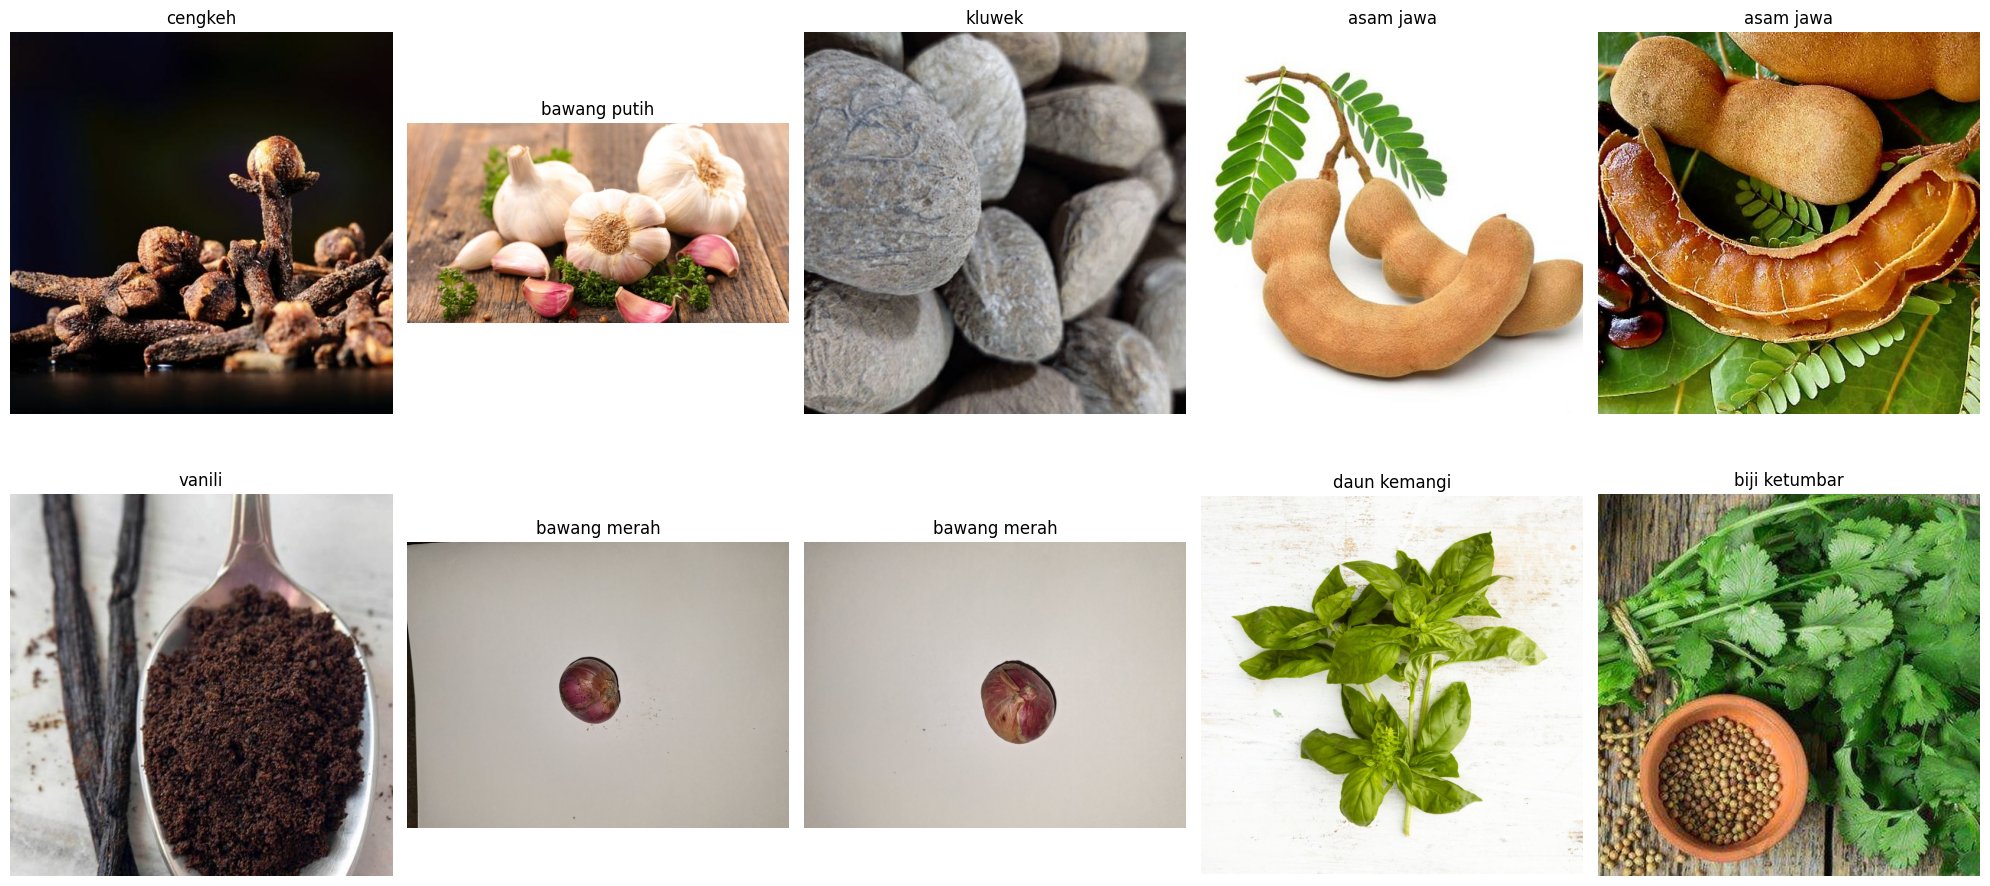

In [9]:
# Random Spices Images
num_images = 10

# Randomly select images to display
random_indices = random.sample(range(len(df_images)), num_images)
random_images = df_images.iloc[random_indices]

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for ax, (index, row) in zip(axes, random_images.iterrows()):
    img = Image.open(row['image_path'])
    ax.imshow(img)
    ax.set_title(row['label'])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Define the split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Stratified split for training and temp
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_size, random_state=42)
for train_idx, temp_idx in stratified_split.split(df_images, df_images['label']):
    train_df = df_images.iloc[train_idx]
    temp_df = df_images.iloc[temp_idx]

# Stratified split for validation and test
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size / (test_size + val_size), random_state=42)
for val_idx, test_idx in stratified_split.split(temp_df, temp_df['label']):
    val_df = temp_df.iloc[val_idx]
    test_df = temp_df.iloc[test_idx]

print(f'Train set: {train_df.shape}')
print(f'Validation set: {val_df.shape}')
print(f'Test set: {test_df.shape}')

Train set: (4556, 2)
Validation set: (977, 2)
Test set: (977, 2)


In [11]:
# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for normalization and reshaping
training_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = ImageDataGenerator(rescale=1/255.0)

# Create DataFrame iterators for training, validation, and test sets
train_generator = training_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

warnings.filterwarnings("ignore")

def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, in fact, an image
        img = Image.open(image_path)
        if img.mode in ("P", "1"):  # Check if image is palette or binary
          img = img.convert("RGBA")
        return True
    except (IOError, SyntaxError) as e:
        print(f"Bad file: {image_path} ({e})")
        return False

# Check all images in the test dataframe
invalid_images = []
for img_path in tqdm(test_df['image_path']):
    if not is_valid_image(img_path):
        invalid_images.append(img_path)

for img_path in tqdm(train_df['image_path']):
    if not is_valid_image(img_path):
        invalid_images.append(img_path)

for img_path in tqdm(val_df['image_path']):
    if not is_valid_image(img_path):
        invalid_images.append(img_path)

print(f'Found {len(invalid_images)} invalid images.')

# Load batch of data
try:
  train_images, train_labels = next(train_generator)
  print(f'Training images shape: {train_images.shape}')
  print(f'Training labels shape: {train_labels.shape}')


  val_images, val_labels = next(val_generator)
  print(f'Validation images shape: {val_images.shape}')
  print(f'Validation labels shape: {val_labels.shape}')

  test_images, test_labels = next(test_generator)
  print(f'Test images shape: {test_images.shape}')
  print(f'Test labels shape: {test_labels.shape}')

except Exception as e:
    print(f"Error loading batch: {e}")

Found 4556 validated image filenames belonging to 31 classes.
Found 977 validated image filenames belonging to 31 classes.
Found 977 validated image filenames belonging to 31 classes.


100%|██████████| 977/977 [00:00<00:00, 4514.59it/s]


Found 0 invalid images.
Training images shape: (32, 224, 224, 3)
Training labels shape: (32, 31)
Validation images shape: (32, 224, 224, 3)
Validation labels shape: (32, 31)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32, 31)


In [12]:
# Count the number of images per label in each DataFrame
train_label_counts = train_df['label'].value_counts()
val_label_counts = val_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Print the counts
print("Training set label counts:")
print(train_label_counts)

print("\nValidation set label counts:")
print(val_label_counts)

print("\nTest set label counts:")
print(test_label_counts)

Training set label counts:
label
cengkeh          147
kayu secang      147
kencur           147
jahe             147
saffron          147
bukan rempah     147
serai            147
pala             147
jinten           147
daun salam       147
andaliman        147
bunga lawang     147
bawang bombai    147
adas             147
asam jawa        147
kunyit           147
lengkuas         147
daun ketumbar    147
kluwek           147
daun kemangi     147
bawang merah     147
lada             147
kemiri           147
kayu manis       147
bawang putih     147
wijen            147
kapulaga         147
vanili           147
kemukus          147
daun jeruk       147
biji ketumbar    146
Name: count, dtype: int64

Validation set label counts:
label
serai            32
vanili           32
jahe             32
bawang putih     32
adas             32
kayu secang      32
bawang merah     32
lengkuas         32
daun salam       32
biji ketumbar    32
cengkeh          32
lada             32
daun jeruk    

In [13]:
# Create a dictionary to map class indices back to class names
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}

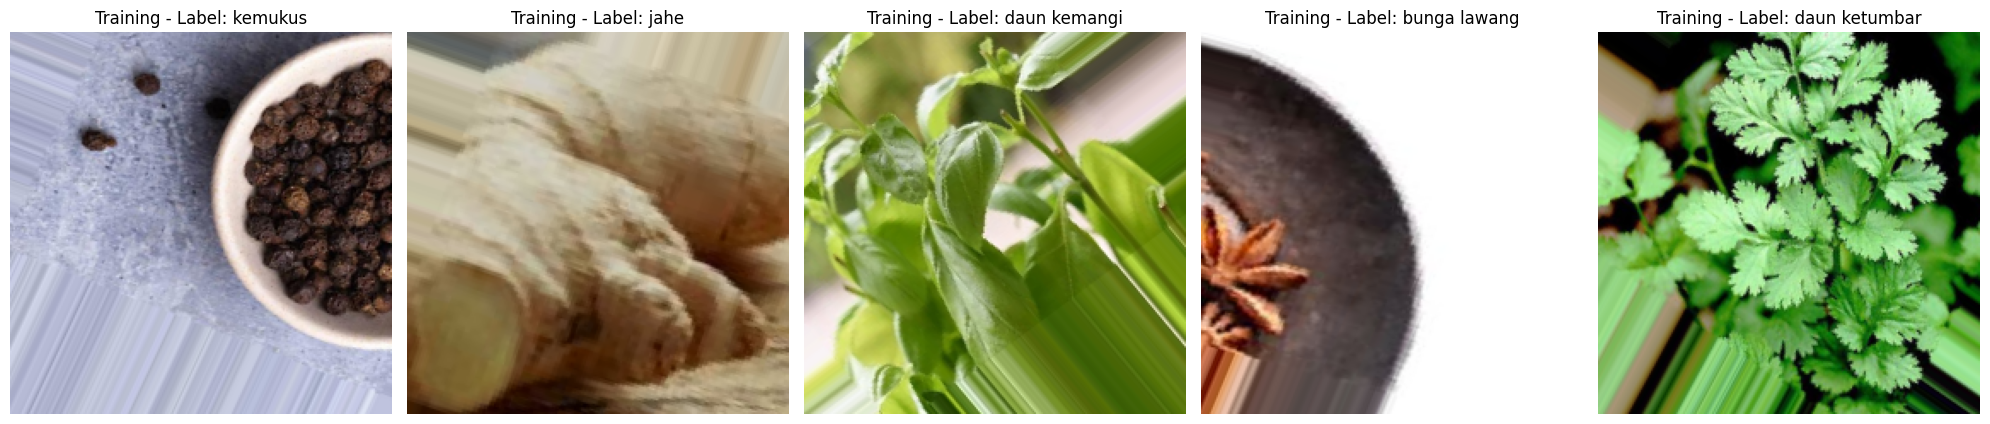

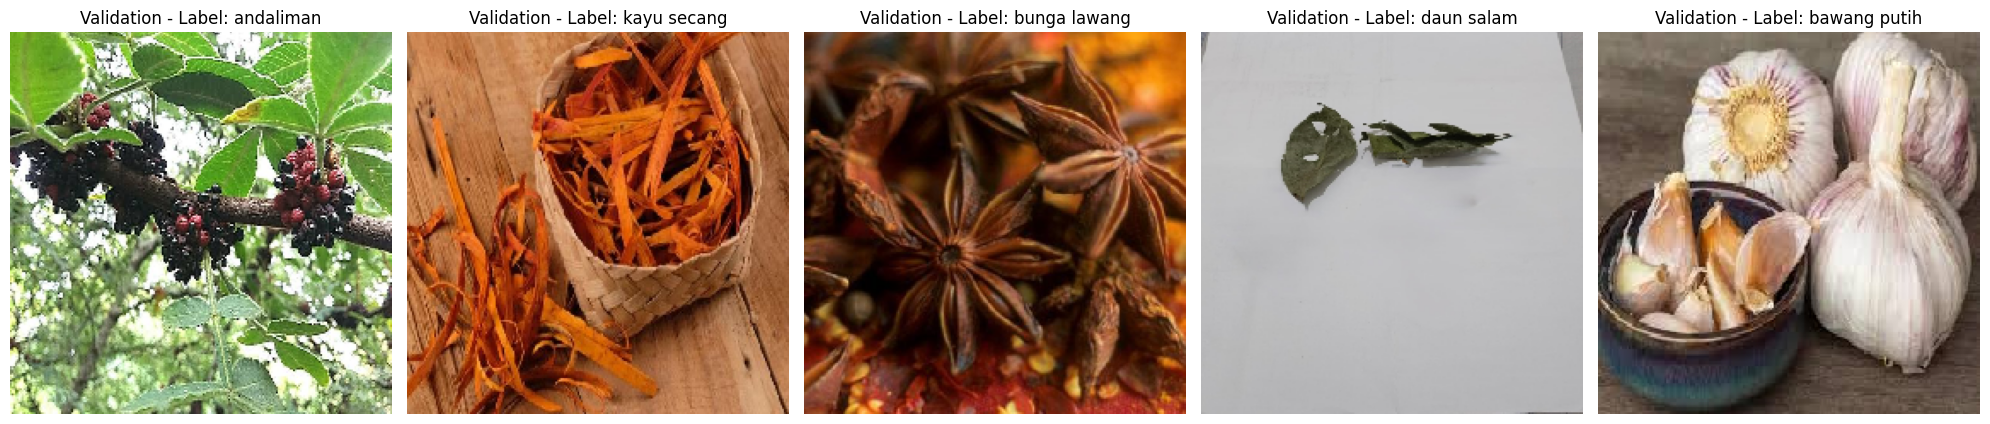

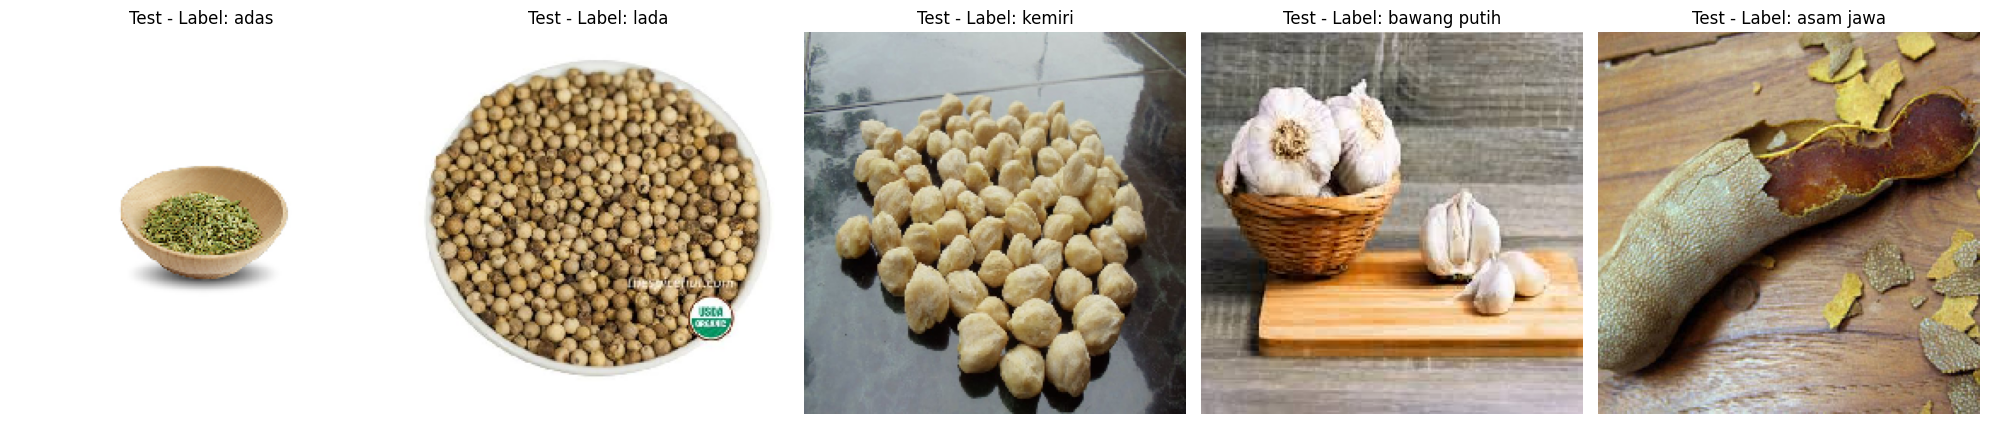

In [14]:
# Function to plot random images from a given generator
def plot_random_images(generator, title, num_images):
    images, labels = next(generator)
    random_indices = np.random.choice(len(images), num_images, replace=False)

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx])
        plt.title(f'{title} - Label: {index_to_class[np.argmax(labels[idx])]}')
        plt.axis('off')
    plt.tight_layout()

# Number of images to display from each set
num_images = 5

# Plot random images from the training set
plot_random_images(train_generator, 'Training', num_images)

# Plot random images from the validation set
plot_random_images(val_generator, 'Validation', num_images)

# Plot random images from the test set
plot_random_images(test_generator, 'Test', num_images)

plt.show()

In [15]:
weights_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.4/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the Xception model
pre_trained_model = Xception(input_shape=(224, 224, 3),
                             include_top=False,
                             weights='imagenet')

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

for layer in pre_trained_model.layers[-20:]:
     layer.trainable = True

# pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

83683744/83683744 [==============================] - 3s 0us/step
Last layer output shape:  (None, 7, 7, 2048)


In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
# Add another fully connected layer with 256 hidden units and ReLU activation
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(31, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

In [17]:
# compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

# train the model
history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=50,
            verbose=1)

Epoch 1/50
143/143 [==============================] - 109s 649ms/step - loss: 4.0720 - acc: 0.0948 - val_loss: 1.9083 - val_acc: 0.4719
Epoch 2/50
143/143 [==============================] - 88s 615ms/step - loss: 2.6405 - acc: 0.2976 - val_loss: 1.0522 - val_acc: 0.6817
Epoch 3/50
143/143 [==============================] - 90s 632ms/step - loss: 1.7376 - acc: 0.5015 - val_loss: 0.7859 - val_acc: 0.7533
Epoch 4/50
143/143 [==============================] - 86s 600ms/step - loss: 1.3597 - acc: 0.6071 - val_loss: 0.6026 - val_acc: 0.8188
Epoch 5/50
143/143 [==============================] - 87s 607ms/step - loss: 1.1067 - acc: 0.6776 - val_loss: 0.5217 - val_acc: 0.8434
Epoch 6/50
143/143 [==============================] - 86s 604ms/step - loss: 0.9017 - acc: 0.7360 - val_loss: 0.4466 - val_acc: 0.8700
Epoch 7/50
143/143 [==============================] - 87s 606ms/step - loss: 0.7710 - acc: 0.7785 - val_loss: 0.4431 - val_acc: 0.8721
Epoch 8/50
143/143 [==============================] - 

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)

print("    Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

31/31 [==============================] - 6s 179ms/step - loss: 0.4042 - acc: 0.9191
    Test Loss: 0.40423
Test Accuracy: 91.91%


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'] 

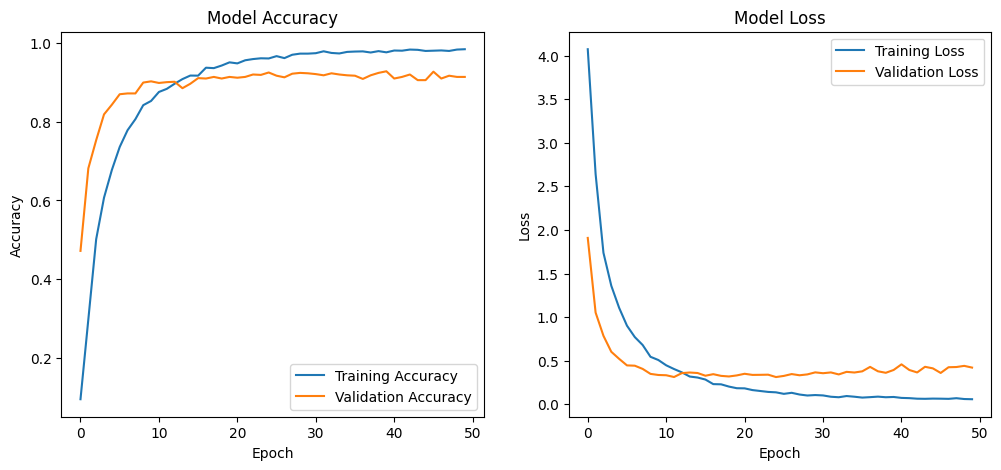

In [20]:
# Function to plot the history
def plot_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Training Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

plot_history(history)

In [21]:
# Predict the labels for your test data
test_generator.reset()  # Ensure the generator is at the start
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# Get the true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

31/31 [==============================] - 6s 182ms/step


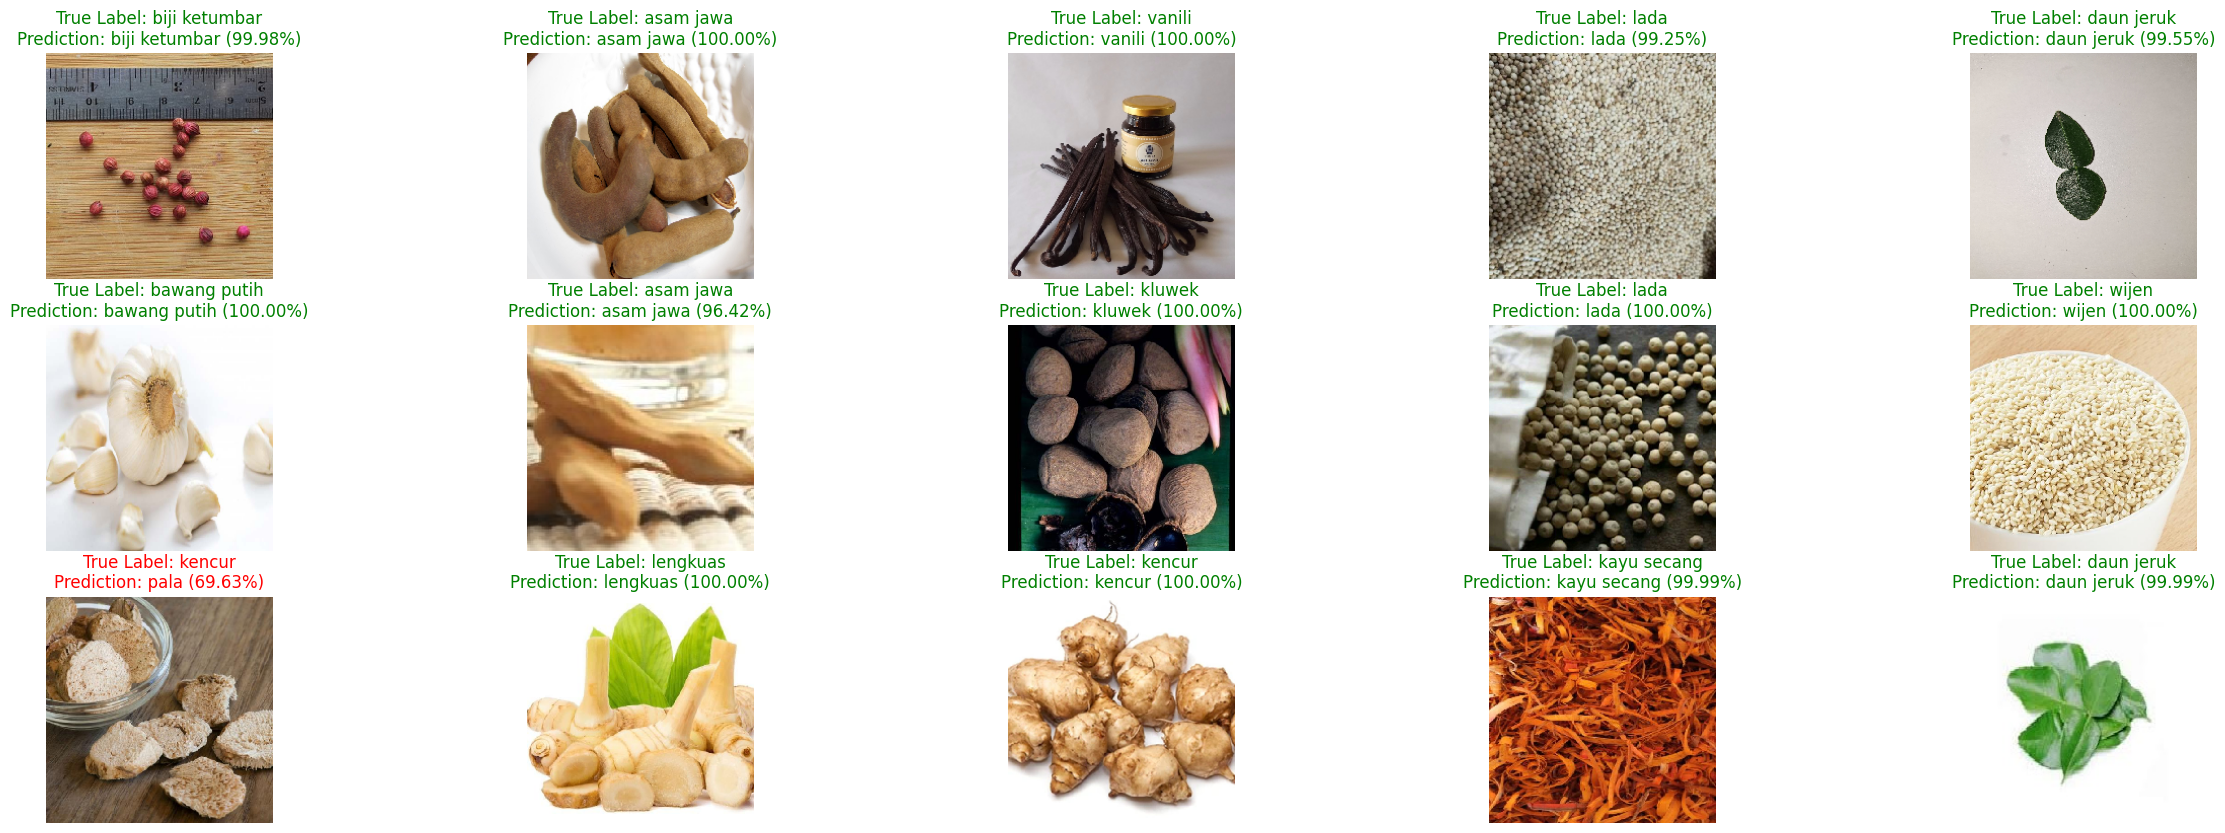

In [26]:
# Function to plot random images with their true and predicted labels
def plot_random_images(generator, predictions, true_classes, class_labels, num_images=15):
    plt.figure(figsize=(30, 10))

    # Get all image file paths and corresponding labels
    all_images, all_labels = [], []
    for i in range(len(generator)):
        images, labels = generator[i]
        all_images.extend(images)
        all_labels.extend(labels)

    # Randomly select a subset of images
    indices = random.sample(range(len(all_images)), num_images)
    selected_images = [all_images[i] for i in indices]
    selected_true_labels = [all_labels[i] for i in indices]
    selected_pred_labels = [predictions[i] for i in indices]
    selected_confidence_scores = [confidence_scores[i] for i in indices]

    for i in range(num_images):
        # Get the true and predicted label for this image
        true_label = class_labels[np.argmax(selected_true_labels[i])]
        predicted_label = class_labels[selected_pred_labels[i]]
        confidence_score = selected_confidence_scores[i]

        # Set the title color: green if correct, red if wrong
        title_color = 'green' if true_label == predicted_label else 'red'

        # Plot the image
        plt.subplot(3, num_images // 3, i + 1)
        plt.imshow(selected_images[i])
        plt.title(f'True Label: {true_label}\nPrediction: {predicted_label} ({confidence_score:.2%})', color=title_color)
        plt.axis('off')

    plt.show()

# Plot 10 random images from test set
plot_random_images(test_generator, predicted_classes, true_classes, class_labels, num_images=15)

               precision    recall  f1-score   support

         adas       0.88      0.97      0.92        31
    andaliman       1.00      0.88      0.93        32
    asam jawa       0.97      0.97      0.97        32
bawang bombai       0.94      1.00      0.97        32
 bawang merah       1.00      0.97      0.98        31
 bawang putih       0.97      0.97      0.97        31
biji ketumbar       0.81      0.81      0.81        32
 bukan rempah       1.00      1.00      1.00        32
 bunga lawang       1.00      0.97      0.98        32
      cengkeh       0.90      0.84      0.87        31
   daun jeruk       0.89      1.00      0.94        31
 daun kemangi       1.00      0.97      0.98        32
daun ketumbar       1.00      1.00      1.00        31
   daun salam       0.97      0.90      0.93        31
         jahe       1.00      0.65      0.78        31
       jinten       0.94      0.91      0.92        32
     kapulaga       0.88      0.94      0.91        31
   kayu m

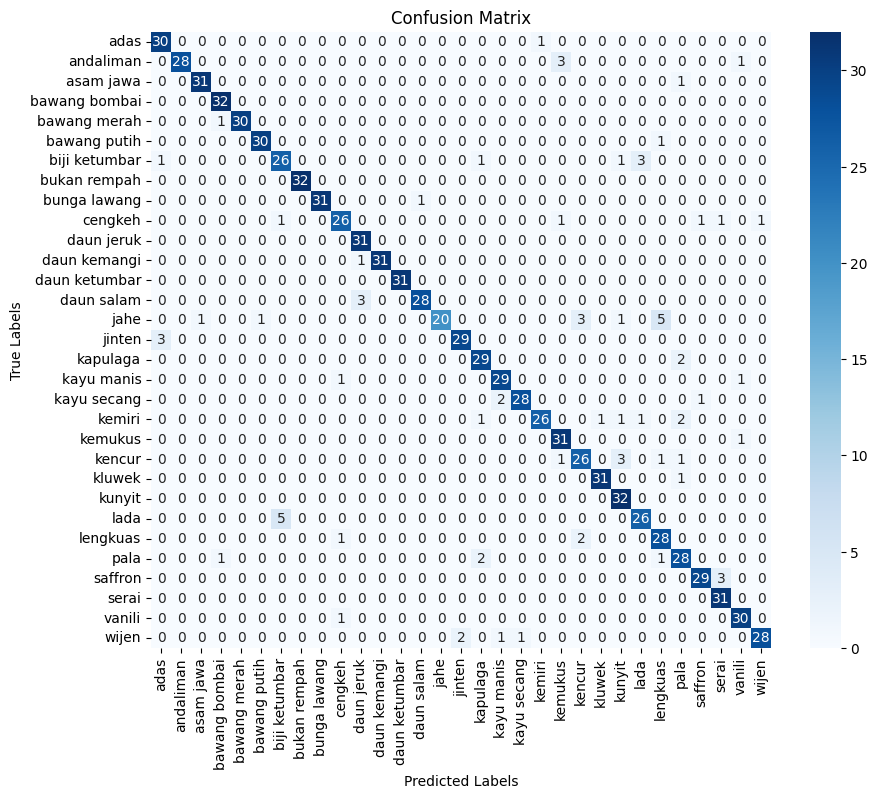

In [23]:
# Generate and display the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [24]:
model.save('Spices-classification_Xception.h5')

In [25]:
h5_path = 'Spices-classification_Xception.h5'

# Download the specified file
files.download(h5_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>